In [1]:
#
import dolfin as df
import numpy as np
import matplotlib.pyplot as plt
import time
import os

from pfbase_ali_mod import *
from ufl import split, dx, inner, grad, variable, diff

save_solution = True

In [3]:

###################################
# Optimization options for the finite element form compiler
###################################
df.parameters["form_compiler"]["cpp_optimize"] = True
df.parameters['form_compiler']['cpp_optimize_flags'] = '-O3 -ffast-math'
df.parameters["form_compiler"]["quadrature_degree"] = 3

###################################
# Create or read mesh
###################################
Lx = Ly = 100.0
Nx = Ny = 100
mesh = df.RectangleMesh(df.Point(0.0, 0.0), df.Point(Lx, Ly), Nx, Ny, 'crossed')



In [4]:
P1 = df.FunctionSpace(mesh, 'P', 1)
PE = P1.ufl_element()
ME = [PE, PE]
ME = df.MixedElement(ME)
W  = df.FunctionSpace(mesh,  ME)

w  = df.Function(W)
dw = df.TrialFunction(W)
w_ = df.TestFunction(W)

In [13]:
class InitialConditionsBench_lin_el(UserExpression):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def eval(self, values, x):
        # indices
        # c, mu, phi,
        # 0,  1,   2,

        values[0] = df.Constant(0.0)
        values[1] = df.Constant(0.0)

    def value_shape(self):
        return (2,)

In [5]:
#w0 = df.Function(W)
#cc0 = df.Constant(0.0)
#cc1 = df.Constant(0.0)
#w_ic = InitialConditionsBench_ali(cc0, cc1)
#w0.interpolate(w_ic)

# Free energy functional
ux, uy = df.split(w)
ux = df.variable(ux)
uy = df.variable(uy)

In [6]:
# this function returns the total strain tensor components
# vx = x component of the displacement vector, vy = y component of the displacement
def eps(vx, vy):
    duxdx, duxdy = df.grad(vx)
    duydx, duydy = df.grad(vy)
    eps_xx = duxdx
    eps_xy = 0.5*(duxdy+duydx) # eps_yx = eps_xy
    eps_yy = duydy
    return eps_xx, eps_xy, eps_yy 

#plane stress case

E = Constant(1e5)
nu = Constant(0.3)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)

#loading condition
rho_g = 1e-3
f = Constant((0, -rho_g))


def sigma(vx, vy, mu_0 = mu, lmbda0 = lmbda):
    eps_xx, eps_xy, eps_yy = eps(vx, vy)
    
    
    sigma_xx = lmbda0*(eps_xx+eps_yy) + 2*mu_0*eps_xx
    sigma_xy = 2*mu_0*eps_xy                # sigma_yx = sigma_xy
    sigma_yy = lmbda0*(eps_xx+eps_yy) + 2*mu_0*eps_yy
    
    return sigma_xx, sigma_xy, sigma_yy

In [ ]:
a = ux_*(sigma_xx_x+sigma_xy_x)*dx + 

In [19]:



def F_ux_weak_form(ux_, vx, vy, fx):
    sigma_xx, sigma_xy, sigma_yy = sigma(vx, vy)
    sigma_xx_x, sigma_xx_y = df.grad(sigma_xx)
    sigma_xy_x, sigma_xy_y = df.grad(sigma_xy)

    lhs =  ux_*(sigma_xx_x+sigma_xy_x)*dx
    rhs = ux_*fx*dx

    F = lhs - rhs

    return F

def F_uy_weak_form(uy_, vx, vy, fy):
    sigma_xx, sigma_xy, sigma_yy = sigma(vx, vy)
    sigma_yy_x, sigma_yy_y = df.grad(sigma_yy)
    sigma_xy_x, sigma_xy_y = df.grad(sigma_xy)

    lhs =  uy_*(sigma_yy_y+sigma_xy_y)*dx
    rhs = uy_*fy*dx

    F = lhs - rhs

    return F

In [24]:
F_mx = F_ux_weak_form(w_[0], w[0], w[1], f[0])
F_my = F_ux_weak_form(w_[1], w[0], w[1], f[1])
F = F_mx + F_my

Wux, Wuy = W.split()

In [39]:
tol = 1E-12
def boundary_left(x, on_boundary):
    return on_boundary and df.near(x[0], 0, tol)

bc_ux_left  = df.DirichletBC(Wux, df.Constant(0.0), boundary_left)
bc_uy_left  = df.DirichletBC(Wuy, df.Constant(0.0), boundary_left)



bcs = [bc_ux_left, bc_uy_left]  # no-flux on top, bottom boundary

###############
J = df.derivative(F, w, dw)



In [27]:

###################################
# Nonlinear solver setup
###################################
df.set_log_level(df.LogLevel.ERROR)

problem = df.NonlinearVariationalProblem(F, w, bcs, J)
solver  = df.NonlinearVariationalSolver(problem)

#solver.parameters['nonlinear_solver'] = 'newton'
#nlparams  = solver.parameters['newton_solver']

solver.parameters['nonlinear_solver'] = 'snes'
nlparams  = solver.parameters['snes_solver']

nlparams['report'] = True
nlparams['error_on_nonconvergence'] = False
nlparams['absolute_tolerance'] = 1e-6
nlparams['maximum_iterations'] = 10

#
# bactracig (bt) diverges with only Laplace eqn
#nlparams['line_search'] = 'bt'      # WORKS (7s) for np=32, T=3.0
nlparams['line_search'] = 'cp'       # (8s) #
#nlparams['line_search'] = 'basic'   # (7s)
#nlparams['line_search'] = 'nleqerr' # (15s)
#nlparams['line_search'] = 'l2'      # FAILING

# 
nlparams['linear_solver'] = 'gmres'
nlparams['preconditioner'] = 'sor'

#nlparams['linear_solver'] = 'gmres'
#nlparams['linear_solver'] = 'bicgstab'
#nlparams['linear_solver'] = 'minres'

#nlparams['preconditioner'] = 'none'
#nlparams['preconditioner'] = 'sor'
#nlparams['preconditioner'] = 'petsc_amg'
#nlparams['preconditioner'] = 'hypre_amg'

nlparams['krylov_solver']['maximum_iterations'] = 5000
#nlparams['krylov_solver']['monitor_convergence'] = True


Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/andrew/anaconda3/envs/PF-env/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/andrew/anaconda3/envs/PF-env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Calling FFC just-in-time (JIT) compiler, this may take some time.


In [43]:

# Ensure everything is reset
t = df.Constant(0.0)
tprev = 0.0
dt = df.Constant(1e-1)

benchmark_output = []
end_time = df.Constant(1) # 400.0
iteration_count = 0
dt_min = 1e-4
dt.assign(1e-2)
t1 = time.time()

while float(t) < float(end_time) + df.DOLFIN_EPS:

    tprev = float(t)

    iteration_count += 1
    if df.MPI.rank(mesh.mpi_comm()) == 0:
        print(f'Iteration #{iteration_count}. Time: {float(t)}, dt: {float(dt)}')
    else:
        pass

    # set IC
    w0.assign(w)

    # solve
    t.assign(tprev + float(dt))
    niters, converged = solver.solve()

    while not converged:
        #if float(dt) < dt_min + 1E-8:
        #    if df.MPI.rank(mesh.mpi_comm()) == 0:
        #        print("dt too small. exiting.")
        #    postprocess()
        #    exit()

        dt.assign(max(0.5*float(dt), dt_min))
        t.assign(tprev + float(dt))
        w.assign(w0)

        if df.MPI.rank(mesh.mpi_comm()) == 0:
            print(f'REPEATING Iteration #{iteration_count}. Time: {float(t)}, dt: {float(dt)}')
        niters, converged = solver.solve()


Iteration #1. Time: 0.0, dt: 0.01
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.005, dt: 0.005
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0025, dt: 0.0025
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.00125, dt: 0.00125
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.000625, dt: 0.000625
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0003125, dt: 0.0003125
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.00015625, dt: 0.00015625
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416

  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001, dt: 0.0001
  0 SNES Function norm 7.416310852888e-02 
REPEATING Iteration #1. Time: 0.0001,

KeyboardInterrupt: 

In [44]:
ux, uy = w.split()

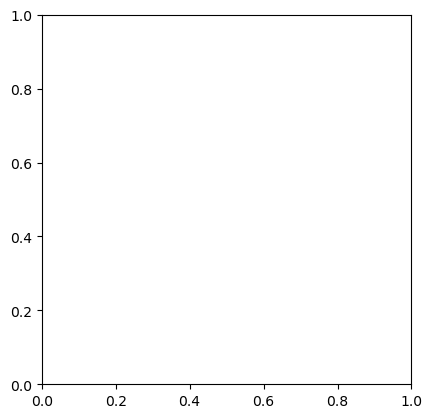

In [47]:
plot(ux*1e3, mode='displacement')
